In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import pickle
import tifffile
import sys
from astropy.visualization import AsymmetricPercentileInterval, LogStretch, MinMaxInterval


In [2]:
WORKDIR='/home/daniel/gdrive/EPFL/2019-2020/MachineLearning/Project/gravitational_lens_ml'
SRC = os.path.join(WORKDIR, 'src')
DATA = os.path.join(WORKDIR,'data')
RESULTS = os.path.join(WORKDIR, 'results')
TRAIN = os.path.join(DATA, 'datapack2.0train/Public')
TEST = os.path.join(DATA, 'datapack2.0test/Public')
TRAIN_MULTIBAND = os.path.join(DATA, 'train_multiband_bin')
TRAIN_MULTIBAND_NOCLIP = os.path.join(DATA, 'train_multiband_noclip_bin')
TEST_MULTIBAND = os.path.join(DATA, 'test_multiband')
CHECKPOINTS = os.path.join(RESULTS, 'checkpoints')
REPORT = os.path.join(WORKDIR, 'report')

In [3]:
image_catalog = pd.read_csv(os.path.join(DATA, 'catalog/image_catalog2.0train.csv'), comment='#', index_col=0)
print(image_catalog.shape)
display(image_catalog.isna().sum(axis=0))
# No effective magnification for 11182 records.

(100009, 26)


ID                  0
x_crit              0
y_crit              0
source_ID           0
z_source            0
z_lens              0
mag_source          0
ein_area            0
n_crit              0
r_source            0
crit_area           0
n_pix_source        0
source_flux         0
n_pix_lens          0
lens_flux           0
n_source_im         0
mag_eff         11182
sb_contrast         0
color_diff          0
n_gal_3             0
n_gal_5             0
n_gal_10            0
halo_mass           0
star_mass           0
mag_lens            0
n_sources           0
dtype: int64

In [4]:
band = 'EUC_VIS'
def get_file_id(filename, delimiters = '_|\.|-'):
    id_ = [int(s) for s in re.split(delimiters, filename) if s.isdigit()][0]
    return id_
file_id_train = np.array([get_file_id(f) for f in os.listdir(os.path.join(TRAIN, band))], dtype=int)
file_id_test = np.array([get_file_id(f) for f in os.listdir(os.path.join(TEST, band))], dtype=int)
def check_existing_files(band, set_):
    for ID in image_catalog.ID:
        if not os.path.isfile(os.path.join(set_, band,'image%s-%i.fits'%(band, ID))):
            print('File image%s-%i.fits does not exist in set.'%(band, ID))
missing_img =  np.setdiff1d(image_catalog.ID.values, file_id_train, assume_unique=False)
print(file_id_train.shape)
print(missing_img)

(99991,)
[213913 226305 233597 244071 259871 261145 270458 288731 294173]


In [5]:
image_catalog['is_lens'] = (image_catalog['mag_lens'] > 1.2) & (image_catalog['n_sources'] != 0)
print('Number of lenses: %i'%image_catalog['is_lens'].sum())

Number of lenses: 90003


In [6]:
image_catalog['img_exists'] = True
image_catalog['img_exists'].loc[image_catalog['ID'].isin(missing_img)] = False

/home/daniel/anaconda3/envs/gravitational_lens_ml/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
image_catalog = image_catalog.drop_duplicates('ID')

In [8]:
lens_cat = image_catalog[image_catalog['is_lens']==True]
nonlens_cat = image_catalog[image_catalog['is_lens']==False]

In [9]:
print('Lenses: %i'%len(image_catalog[image_catalog['is_lens']==True]))
print('Non-lenses: %i'%len(image_catalog[image_catalog['is_lens']==False]))

Lenses: 89995
Non-lenses: 10005


In [10]:
example_lens=lens_cat.iloc[0,0]
example_nonlens=nonlens_cat.iloc[0,0]
print(example_lens, example_nonlens)

200001 200003


In [11]:
import aplpy 
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp

In [12]:
def get_image_filename_from_id(id_, band, set_=TRAIN, ext='fits'):
    fname = os.path.join(set_, '{0}/image{0}-{1}.{2}'.format(band, id_, ext))
    return fname

fig = plt.figure()
def plot_all_bands_from_id(id_,
                           fig=fig,
                           pmin=0,
                           pmax=100,
                           subplot_line=1,
                           total_subplot_lines=1):
    bands = ['EUC_VIS', 'EUC_H', 'EUC_Y', 'EUC_J']
    fitsfigs = []
    data = []
    for i, band in enumerate(bands):
        subplot_id = np.ravel_multi_index((subplot_line - 1, i),
                                          (subplot_line, 4)) + 1
        with fits.open(get_image_filename_from_id(id_, band)) as hdu:
            data.append(hdu[0].data)
        fitsfigs.append(
            aplpy.FITSFigure(data[i],
                             figure=fig,
                             subplot=(total_subplot_lines, 4, subplot_id)))
        fitsfigs[i].show_colorscale(pmin=pmin, pmax=pmax)
        fitsfigs[i].set_theme('publication')
        fitsfigs[i].set_title(band)
        fitsfigs[i].add_colorbar()


def plot_all_bands_from_array(id_,
                              fig=fig,
                              pmin=0,
                              pmax=100,
                              path=TRAIN_MULTIBAND,
                              subplot_line=1,
                              total_subplot_lines=1):
    bands = ['EUC_VIS', 'EUC_H', 'EUC_Y', 'EUC_J']
    image_path = os.path.join(path, 'image_%i_multiband.npy' % id_)
    image = np.load(image_path)
    fitsfigs = []
    for i, band in enumerate(bands):
        subplot_id = np.ravel_multi_index((subplot_line - 1, i),
                                          (subplot_line, 4)) + 1
        fitsfigs.append(
            aplpy.FITSFigure(image[:, :, i],
                             figure=fig,
                             subplot=(total_subplot_lines, 4, subplot_id)))
        fitsfigs[i].show_colorscale(pmin=pmin, pmax=pmax)
        fitsfigs[i].set_theme('publication')
        fitsfigs[i].set_title(band)
        fitsfigs[i].add_colorbar()

<Figure size 432x288 with 0 Axes>

In [13]:
def plot_processing_from_id(id_,
                           fig=fig,
                           pmin=0,
                           pmax=100):
    bands = ['EUC_VIS', 'EUC_H', 'EUC_Y', 'EUC_J']
    image_path_clip = os.path.join(TRAIN_MULTIBAND, 'image_%i_multiband.npy' % id_)
    image_clip = np.load(image_path_clip)
    image_path = os.path.join(TRAIN_MULTIBAND_NOCLIP, 'image_%i_multiband.npy' % id_)
    image = np.load(image_path)
    fitsfigs = []
    data = []
    for i, band in enumerate(bands):
        with fits.open(get_image_filename_from_id(id_, band)) as hdu:
            data.append(hdu[0].data)
        original = aplpy.FITSFigure(data[i],
                             figure=fig,
                             subplot=(3, 4, i+1))
        noclip = aplpy.FITSFigure(image[:,:,i],
                             figure=fig,
                             subplot=(3, 4, 4+i+1))
        clip = aplpy.FITSFigure(image_clip[:,:,i],
                             figure=fig,
                             subplot=(3, 4, 8+i+1))
        imgs = [original, noclip, clip]
        for case in imgs:
            case.show_colorscale(pmin=pmin, pmax=pmax)
            case.set_theme('publication')
            case.add_colorbar()
        original.set_title(band)

INFO: Auto-setting vmin to -1.484e-11 [aplpy.core]
INFO: Auto-setting vmax to  1.420e-10 [aplpy.core]
INFO: Auto-setting vmin to -6.361e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.101e+00 [aplpy.core]
INFO: Auto-setting vmin to -1.000e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.110e+00 [aplpy.core]


INFO: Auto-setting vmin to -6.783e-10 [aplpy.core]
INFO: Auto-setting vmax to  7.104e-09 [aplpy.core]
INFO: Auto-setting vmin to  9.366e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.025e+00 [aplpy.core]
INFO: Auto-setting vmin to -1.000e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.110e+00 [aplpy.core]


INFO: Auto-setting vmin to -3.888e-10 [aplpy.core]
INFO: Auto-setting vmax to  3.987e-09 [aplpy.core]
INFO: Auto-setting vmin to  1.097e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.062e+00 [aplpy.core]
INFO: Auto-setting vmin to -1.000e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.110e+00 [aplpy.core]


INFO: Auto-setting vmin to -5.284e-10 [aplpy.core]
INFO: Auto-setting vmax to  5.371e-09 [aplpy.core]
INFO: Auto-setting vmin to  1.947e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.056e+00 [aplpy.core]
INFO: Auto-setting vmin to -1.000e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.110e+00 [aplpy.core]


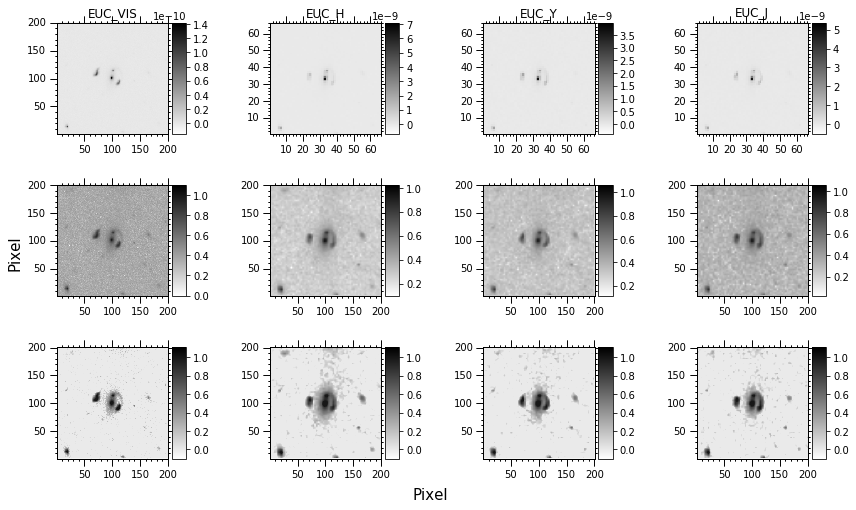

In [14]:
fig = plt.figure(figsize=(12, 7))
plot_processing_from_id(example_lens, fig=fig)
axes = fig.axes
[a.set_xlabel('') for a in axes]
[a.set_ylabel('') for a in axes]
fig.text(0.5, 0.01, 'Pixel', ha='center', fontsize=15)
fig.text(0.01, 0.5, 'Pixel', va='center', rotation='vertical', fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(REPORT, 'lens_processing.png'), dpi=150)

INFO: Auto-setting vmin to -2.197e-11 [aplpy.core]
INFO: Auto-setting vmax to  2.213e-10 [aplpy.core]
INFO: Auto-setting vmin to  1.189e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.061e+00 [aplpy.core]
INFO: Auto-setting vmin to -1.000e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.110e+00 [aplpy.core]


INFO: Auto-setting vmin to -1.324e-09 [aplpy.core]
INFO: Auto-setting vmax to  1.431e-08 [aplpy.core]
INFO: Auto-setting vmin to -4.317e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.073e+00 [aplpy.core]
INFO: Auto-setting vmin to -1.000e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.110e+00 [aplpy.core]


INFO: Auto-setting vmin to -7.011e-10 [aplpy.core]
INFO: Auto-setting vmax to  7.430e-09 [aplpy.core]
INFO: Auto-setting vmin to -3.318e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.061e+00 [aplpy.core]
INFO: Auto-setting vmin to -1.000e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.110e+00 [aplpy.core]


INFO: Auto-setting vmin to -9.798e-10 [aplpy.core]
INFO: Auto-setting vmax to  1.041e-08 [aplpy.core]
INFO: Auto-setting vmin to -1.457e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.063e+00 [aplpy.core]
INFO: Auto-setting vmin to -1.000e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.110e+00 [aplpy.core]


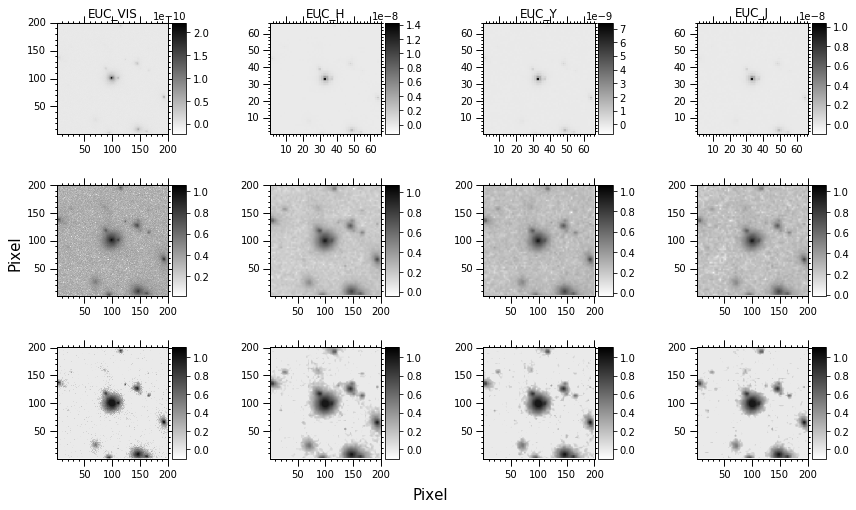

In [15]:
fig = plt.figure(figsize=(12, 7))
plot_processing_from_id(example_nonlens, fig=fig)
axes = fig.axes
[a.set_xlabel('') for a in axes]
[a.set_ylabel('') for a in axes]
fig.text(0.5, 0.01, 'Pixel', ha='center', fontsize=15)
fig.text(0.01, 0.5, 'Pixel', va='center', rotation='vertical', fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(REPORT, 'nonlens_processing.png'), dpi=150)

# Combine bands into `tiff` and test

In [16]:
def build_image(id_, set_, bands = ['EUC_VIS', 'EUC_H', 'EUC_J', 'EUC_Y'], img_size=200, scale = 100):
    tables = []
    data = np.empty((img_size, img_size, len(bands)))
    for i, band in enumerate(bands):
        tables.append(fits.open(get_image_filename_from_id(id_, band)))
        if band != 'EUC_VIS':
            band_data, data_footprint = reproject_interp(tables[i][0], tables[0][0].header)
        else:
            band_data = tables[0][0].data
        band_data[np.isnan(band_data)] = 0.
        interval = AsymmetricPercentileInterval(0.25, 99.75, n_samples=100000)
        vmin, vmax = interval.get_limits(band_data)
        stretch = MinMaxInterval() +  LogStretch()
        data[:,:,i] = stretch(((np.clip(band_data, vmin*(-0.7), vmax))/(vmax)))
    for t in tables:
        t.close()
    return data.astype(np.float32)


640128
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
4719    True
Name: is_lens, dtype: bool


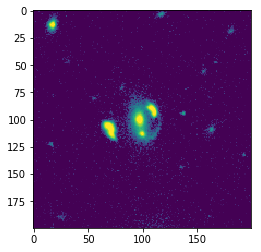

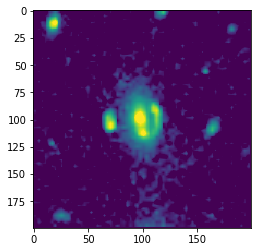

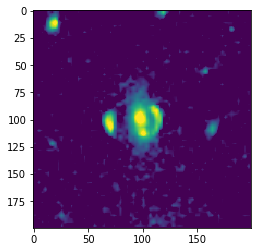

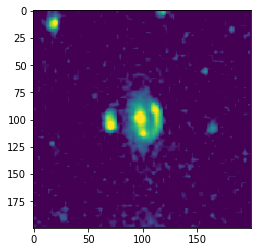

In [17]:
img = build_image(example_lens, TRAIN)
print(sys.getsizeof(img))
for i in range(4):
    plt.figure()
    print(np.min(img[:,:,i]), np.max(img[:,:,i]))
    a = plt.imshow((img[:,:,i]))
print(image_catalog.loc[image_catalog['ID']==example_lens]['is_lens'])

# Compare preprocessing with Log + Norm

In [18]:
def build_image_noprocess(id_, set_, bands = ['EUC_VIS', 'EUC_H', 'EUC_J', 'EUC_Y'], img_size=200, scale = 100):
    tables = []
    data = np.empty((img_size, img_size, len(bands)))
    for i, band in enumerate(bands):
        tables.append(fits.open(get_image_filename_from_id(id_, band)))
        if band != 'EUC_VIS':
            band_data, data_footprint = reproject_interp(tables[i][0], tables[0][0].header)
        else:
            band_data = tables[0][0].data
        band_data[np.isnan(band_data)] = 0.
        norm =  LogStretch() + MinMaxInterval()
        data[:,:,i] = norm(band_data)
    for t in tables:
        t.close()
    return data.astype(np.float32)


In [19]:
test_id = example_lens
img = build_image(test_id, TRAIN)
img_nopr = build_image_noprocess(test_id, TRAIN)
def plot_slice(image, slice_ratio, axis=0):
    '''Plot a single slice of a picture.
    
    image: Image to plot.
    slice_ratio: float from 0 to 1 where 0 is the top slice, and 1 is the last slice.
    axis: 0 or 1 to show horizontal or vertical slices'''
    
    index = int(image.shape[axis] * slice_ratio)
    slice_ = image[index]
    plt.plot(slice_)


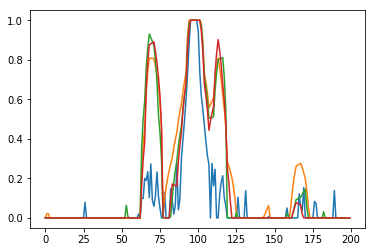

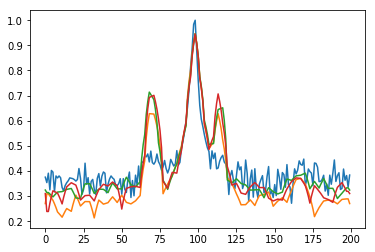

In [20]:
plot_slice(img, 0.5)
plt.figure()
plot_slice(img_nopr, 0.5)

In [21]:
def plot_slice_stack(image, axis=0, **kwargs):
    '''Plot a single slice of a picture.
    
    image: Image to plot.'''
    
    slice_ = np.sum(image, axis=axis)
    print(slice_.shape)
    label = kwargs.pop('label')
    plt.plot(slice_, **kwargs)
    plt.plot(slice_[-1], label=label, **kwargs)
    

(200,)
(200,)


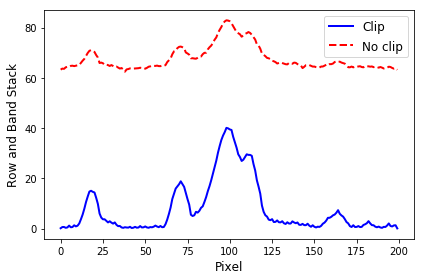

In [22]:
axis = (0)
plot_slice_stack(np.mean(img, axis=2),
                 axis=axis,
                 color='b',
                 alpha=1,
                 label='Clip',
                 ls='-',
                 lw=2)
#plt.figure()
plot_slice_stack(np.mean(img_nopr, axis=2),
                 axis=axis,
                 color='r',
                 alpha=1,
                 label='No clip',
                 ls='--',
                 lw=2)
plt.legend(loc=0, fontsize=12)
plt.xlabel('Pixel', fontsize=12)
plt.ylabel('Row and Band Stack', fontsize=12)
plt.tight_layout()
plt.gcf()
plt.savefig(os.path.join(REPORT, 'preprocessing_stack.png'), dpi=150)

# Model Plot


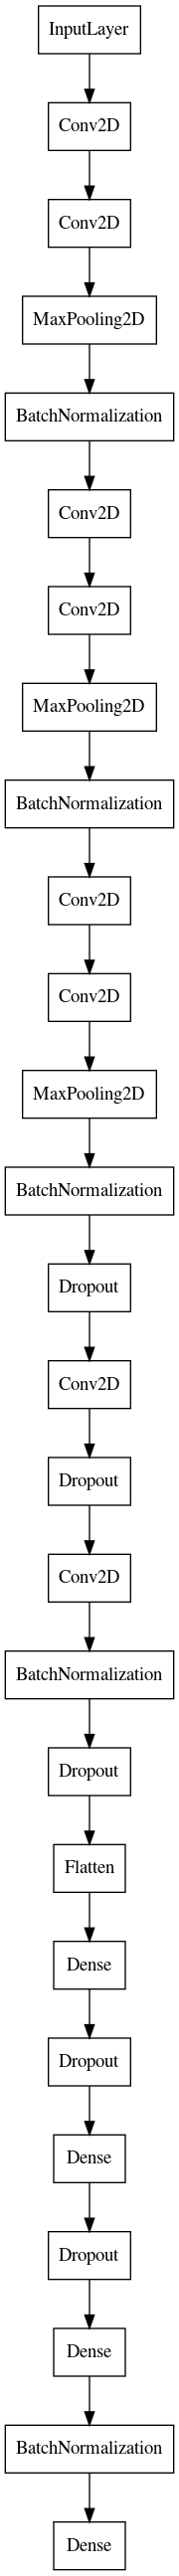

In [23]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

model = load_model(os.path.join(RESULTS, 'lastro_cnn_Tr6000_Te2955_bs10_ep130_aug1_VIS1_NIR111_DBraw_ratio0.5_ks53_ps3_Dropout_train_multiband_bin_BEST.h5'))
plot_model(model, to_file=os.path.join(REPORT, 'lastro_arch.png'), show_shapes=False,show_layer_names=False)


# PCA

In [24]:
img = tifffile.imread(DATA+'/train_multiband_noclip/image_%i_multiband.tiff'%example_nonlens)
def flatten_by_channel(original_image):
    """preprocess the image."""
    n_channels = original_image.shape[-1]
    processed_image = original_image.reshape(-1,n_channels)
    return processed_image.astype(np.float32) #Overflow if using unsigned int
flat_img = flatten_by_channel(img)


In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pca = PCA(whiten=False)
std_flat_img = scaler.fit_transform(flat_img)
pca.fit(std_flat_img)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

<BarContainer object of 4 artists>

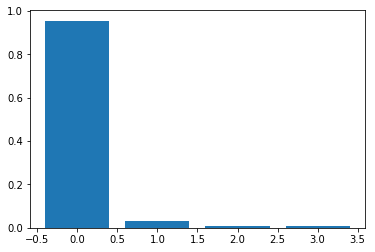

In [26]:
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

In [27]:
pca_flat_img = pca.fit_transform(std_flat_img)
pca_image = pca_flat_img.reshape((img.shape[0], img.shape[1], -1))

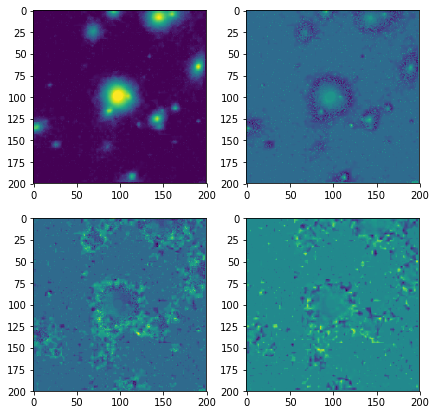

In [28]:
f, ax = plt.subplots(2, 2, figsize = (7, 7))
for i, a in enumerate(ax.ravel()):
    a.imshow(pca_image[:,:,i])

## Covariance Matrix between colors
See, that it is almost diagonal. Not surprising that PC's are almost the same as the priginal colors.

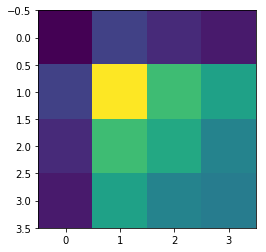

In [29]:
plt.imshow(np.cov(flat_img.T))

# Check History of model training

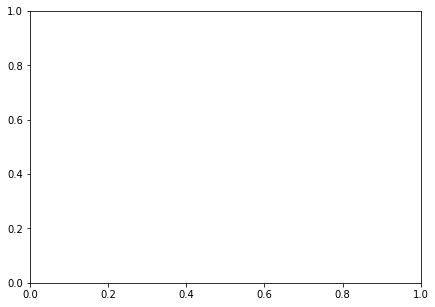

In [30]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
def plot_history(history_path, fig = fig, train_color='r', val_color='b', **kwargs):
    try: l = kwargs.pop('label'); 
    except: 
            l = '\b'
    with open(history_path, 'rb') as handle:
        history = pickle.load(handle)
    if len(fig.axes)<2:
        ax2 = ax1.twinx()
    else: ax2 = fig.axes[1]
    ax1.plot(range(len(history['loss'])),
             history['val_loss'],
             label='Validation loss\n%s'%l,
             c=val_color, **kwargs)
    ax1.plot(range(len(history['loss'])),
             history['loss'],
             label='Training loss\n%s'%l,
             c=train_color, **kwargs)
    ax2.plot(range(len(history['loss'])),
             history['val_acc'],
             label='Validation accuracy\n%s'%l,
             c=val_color,
             ls='-.', **kwargs, fillstyle='none')
    ax2.plot(range(len(history['loss'])),
             history['acc'],
             label='Training accuracy\n%s'%l,
             c=train_color,
             ls='-.', **kwargs, fillstyle='none')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.legend(loc=(1.15, 0.), fontsize=11)
    ax2.legend(loc=(1.15, 0.6), fontsize=11)
    ax1.set_ylabel('Loss', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_ylim(0,1)
    ax1.set_ylim(0.4,1)
    ax1.set_xlim(0,200)
    plt.gcf()


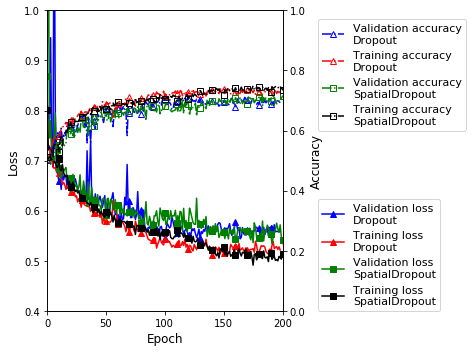

In [31]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))

history_dr = os.path.join(
    RESULTS,
    'lastro_cnn_Tr6000_Te2955_bs10_ep230_aug1_VIS1_NIR111_DBraw_ratio0.5_ks53_ps3_Dropout_train_multiband_bin.history'
)
history_sdr = os.path.join(
    RESULTS,
    'lastro_cnn_Tr6000_Te2955_bs10_ep230_aug1_VIS1_NIR111_DBraw_ratio0.5_ks53_ps3_SpatialDropout2D_train_multiband_bin.history'
)

plot_history(history_dr, fig=fig, marker = '^', markevery=10, label = 'Dropout')
plot_history(history_sdr, fig=fig, train_color='k', val_color='g', marker = 's', markevery=10, label = 'SpatialDropout')
plt.gcf()
fig.tight_layout()
fig.savefig(os.path.join(REPORT, 'learning_curves_lastro.png'), dpi=96)

# Augment vs No augment

In [32]:
noa_noir = os.path.join(RESULTS,'lastro_cnn_Tr66993_Te32998_bs20_ep130_aug0_VIS1_NIR000_DBraw_ratio0.5.FPRvsTPR.dat')
a_noir = os.path.join(RESULTS,'lastro_cnn_Tr66993_Te32998_bs20_ep130_aug1_VIS1_NIR000_DBraw_ratio0.5.FPRvsTPR.dat')

def plot_roc(roc_file, put_metrics=True, **kwargs):
    roc_results = np.loadtxt(roc_file)
    with open(roc_file) as handler:
        header = [next(handler) for x in range(2)]
    saved_metrics = [s.split('=')[-1] for s in header]
    fpr = roc_results[:,0]
    tpr = roc_results[:,1]
    auc = float(saved_metrics[0])
    acc = float(saved_metrics[1])
    plt.figure(2)
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.plot([0, 1], [0, 1], c='k', ls=':')
    try:
        l = kwargs.pop('label')
    except:
        l=''
    if put_metrics:
        label = 'Validation\nAUC=%.3f\nACC=%.3f\n%s'%(auc, acc, l)
    else:
        label= l
    plt.plot(fpr, tpr, label=label ,lw =2, **kwargs)
    plt.legend(loc=0, fontsize=11)   

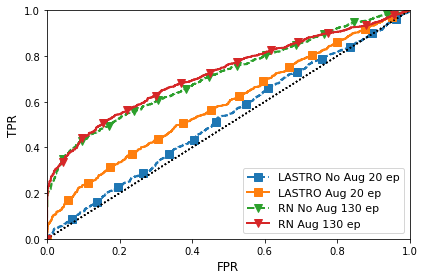

In [33]:
noa_noir = os.path.join(
    RESULTS,
    'lastro_cnn_Tr66993_Te32998_bs20_ep130_aug0_VIS1_NIR000_DBraw_ratio0.5.FPRvsTPR.dat'
)
a_noir = os.path.join(
    RESULTS,
    'lastro_cnn_Tr66993_Te32998_bs20_ep130_aug1_VIS1_NIR000_DBraw_ratio0.5.FPRvsTPR.dat'
)
res_noa_noir = os.path.join(
    RESULTS,
    'RN20v1_Tr6000_Te2955_bs10_ep130_aug0_VIS1_NIR000_DBraw_ratio0.5_dropout.FPRvsTPR.dat'
)
res_a_noir = os.path.join(
    RESULTS,
    'RN20v1_Tr6000_Te2955_bs10_ep130_aug1_VIS1_NIR000_DBraw_ratio0.5_dropout.FPRvsTPR.dat'
)
plot_roc(noa_noir,
         label='LASTRO No Aug 20 ep',
         ls='--',
         put_metrics=False,
         marker='s',
         markevery=100,
        markersize=8)
plot_roc(a_noir,
         label='LASTRO Aug 20 ep',
         ls='-',
         put_metrics=False,
         marker='s',
         markevery=100,
        markersize=8)
plot_roc(res_noa_noir,
         label='RN No Aug 130 ep',
         ls='--',
         put_metrics=False,
         marker='v',
         markevery=100,
        markersize=8)
plot_roc(res_a_noir,
         label='RN Aug 130 ep',
         ls='-',
         put_metrics=False,
         marker='v',
         markevery=100,
        markersize=8)
plt.gcf()
plt.tight_layout()
plt.savefig(os.path.join(REPORT, 'a_vs_noa.png'), dpi=96)

# NIR vs No NIR

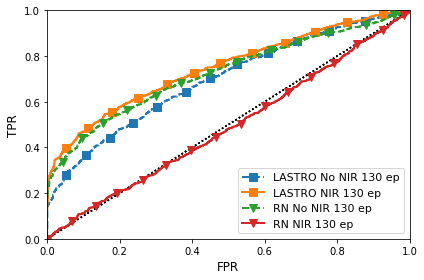

In [34]:
a_noir = RESULTS+'/lastro_cnn_Tr6000_Te2955_bs10_ep130_aug1_VIS1_NIR000_DBraw_ratio0.5_ks53_ps3_SpatialDropout2D_train_multiband_bin.FPRvsTPR.dat'
a_ir = RESULTS+'/lastro_cnn_Tr6000_Te2955_bs10_ep130_aug1_VIS1_NIR111_DBraw_ratio0.5_ks53_ps3_SpatialDropout2D_train_multiband_bin_BEST.FPRvsTPR.dat'
res_a_noir = RESULTS+'/RN20v1_Tr6000_Te2955_bs10_ep130_aug1_VIS1_NIR000_DBraw_ratio0.5_dropout.FPRvsTPR.dat'
res_a_ir = RESULTS+'/RN20v1_Tr6000_Te2955_bs10_ep130_aug1_VIS1_NIR111_DBraw_ratio0.5_dropout.FPRvsTPR.dat'
plot_roc(a_noir,
         label='LASTRO No NIR 130 ep',
         ls='--',
         put_metrics=False,
         marker='s',
         markevery=100,
        markersize=8)
plot_roc(a_ir,
         label='LASTRO NIR 130 ep',
         ls='-',
         put_metrics=False,
         marker='s',
         markevery=100,
        markersize=8)
plot_roc(res_a_noir,
         label='RN No NIR 130 ep',
         ls='--',
         put_metrics=False,
         marker='v',
         markevery=100,
        markersize=8)
plot_roc(res_a_ir,
         label='RN NIR 130 ep',
         ls='-',
         put_metrics=False,
         marker='v',
         markevery=100,
        markersize=8)
plt.gcf()
plt.tight_layout()
plt.savefig(os.path.join(REPORT, 'nir_vs_nonir.png'), dpi=96)

# Best models

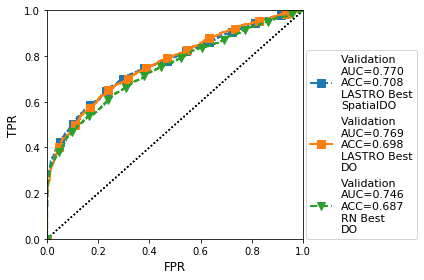

In [35]:
dr_best = RESULTS+'/lastro_cnn_Tr6000_Te2955_bs10_ep230_aug1_VIS1_NIR111_DBraw_ratio0.5_ks53_ps3_Dropout_train_multiband_bin_BEST.FPRvsTPR.dat'
sdr_best = RESULTS+'/lastro_cnn_Tr6000_Te2955_bs10_ep230_aug1_VIS1_NIR111_DBraw_ratio0.5_ks53_ps3_SpatialDropout2D_train_multiband_bin_BEST.FPRvsTPR.dat'
res_best = RESULTS+'/RN20v1_Tr6000_Te2955_bs10_ep230_aug1_VIS1_NIR000_DBraw_ratio0.5_dropout.FPRvsTPR.dat'
plot_roc(sdr_best,
         label='LASTRO Best\nSpatialDO',
         ls='--',
         put_metrics=True,
         marker='s',
         markevery=100,
        markersize=8)
plot_roc(dr_best,
         label='LASTRO Best\nDO',
         ls='-',
         put_metrics=True,
         marker='s',
         markevery=100,
        markersize=8)
plot_roc(res_best,
         label='RN Best\nDO',
         ls='--',
         put_metrics=True,
         marker='v',
         markevery=100,
        markersize=8)
plt.gcf()
plt.legend(loc=(1.01, 0), fontsize=11)
plt.tight_layout()
plt.savefig(os.path.join(REPORT, 'dr_vs_sdr.png'), dpi=96)

## Clip vs No clip

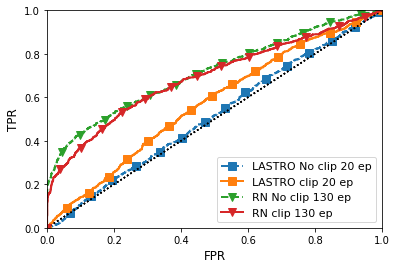

In [36]:
noclip = RESULTS+'/lastro_cnn_Tr6000_Te2955_bs10_ep130_aug1_VIS1_NIR000_DBraw_ratio0.5_ks86_Dropout_train_multiband_noclip_bin.FPRvsTPR.dat'
clip = RESULTS+'/lastro_cnn_Tr6000_Te2955_bs10_ep130_aug1_VIS1_NIR000_DBraw_ratio0.5_ks86_Dropout_train_multiband_bin.FPRvsTPR.dat'
res_noclip = RESULTS+'/RN20v1_Tr6000_Te2955_bs10_ep130_aug0_VIS1_NIR000_DBraw_ratio0.5_dropout.FPRvsTPR.dat'
res_clip = RESULTS+'/RN20v1_Tr6000_Te2955_bs10_ep130_aug0_VIS1_NIR000_DBraw_ratio0.5_dropout_clipped.FPRvsTPR.dat'
plot_roc(noclip,
         label='LASTRO No clip 20 ep',
         ls='--',
         put_metrics=False,
         marker='s',
         markevery=100,
        markersize=8)
plot_roc(clip,
         label='LASTRO clip 20 ep',
         ls='-',
         put_metrics=False,
         marker='s',
         markevery=100,
        markersize=8)
plot_roc(res_noclip,
         label='RN No clip 130 ep',
         ls='--',
         put_metrics=False,
         marker='v',
         markevery=100,
        markersize=8)
plot_roc(res_clip,
         label='RN clip 130 ep',
         ls='-',
         put_metrics=False,
         marker='v',
         markevery=100,
        markersize=8)
plt.gcf()
plt.savefig(os.path.join(REPORT, 'clip_vs_noclip.png'), dpi=96)

# Check total number of epochs trained for

In [37]:
log_dp = RESULTS+'/checkpoints/lastro_cnn/lastro_cnn_Tr6000_Te2955_bs10_ep230_aug1_VIS1_NIR111_DBraw_ratio0.5_ks53_ps3_Dropout_train_multiband_bin.log'
log_sdp = RESULTS+'/checkpoints/lastro_cnn/lastro_cnn_Tr6000_Te2955_bs10_ep230_aug1_VIS1_NIR111_DBraw_ratio0.5_ks53_ps3_Dropout_train_multiband_bin.log'
print(os.path.isfile(log_dp))

True


# Plot false positives


In [38]:
%load_ext autoreload
%autoreload 2
sys.path.insert(1, os.path.realpath(os.path.pardir))
import tensorflow as tf
import data_generator_function
import helpers
from sklearn.model_selection import train_test_split
best_model_name = RESULTS+'/lastro_cnn_Tr6000_Te2955_bs10_ep230_aug1_VIS1_NIR111_DBraw_ratio0.5_ks53_ps3_SpatialDropout2D_train_multiband_bin_BEST.h5'
print(os.path.isfile(best_model_name))
model = tf.keras.models.load_model(best_model_name)

True


In [39]:
lens_df = pd.read_csv(os.path.join(RESULTS, 'lens_id_labels.csv'), index_col=0)
dataframe_for_generator = helpers.build_generator_dataframe(
    lens_df, TRAIN_MULTIBAND)
print(TRAIN_MULTIBAND)
n_val = 100
train_df, val_df = train_test_split(dataframe_for_generator,
                                    train_size=0.001,
                                    random_state=42)
total_train = len(train_df)
total_val = len(val_df)
print(total_val)
image_data_gen_val = data_generator_function.TiffImageDataGenerator(
    dtype='float32')
roc_val_data_gen = image_data_gen_val.prop_image_generator_dataframe(
    val_df,
    directory=TRAIN_MULTIBAND,
    x_col='filenames',
    y_col='labels',
    batch_size=n_val,
    validation=True,
    ratio=0.5,
    bands=[True, True, True, True],
    binary=True,
    get_ids=True,
    id_col='filenames')
images_val, labels_true, ids = next(roc_val_data_gen)
labels_score = model.predict(images_val,
                             batch_size=10,
                             verbose=2,
                             workers=16,
                             use_multiprocessing=True)
truth = (labels_true == 1)
predictions = (labels_score>0.5).reshape(-1)

FP = []
for i in range(len(truth)):
    if not(truth[i]) and predictions[i]:
        FP.append(True)
    else:
        FP.append(False)
FP = np.array(FP)
fpr = np.mean(FP)

/home/daniel/gdrive/EPFL/2019-2020/MachineLearning/Project/gravitational_lens_ml/data/train_multiband_bin
3523
10/1 - 1s


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv2d/Relu (defined at /home/daniel/anaconda3/envs/gravitational_lens_ml/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_distributed_function_10741]

Function call stack:
distributed_function


In [ ]:
print(fpr)
fp_ids = ids[FP]
n_fp = len(fp_ids)
max_arr_side = 5
array_side = min(int(np.sqrt(n_fp)), max_arr_side)
fig, ax = plt.subplots(array_side, array_side, figsize=(10, 10))
for i, a in enumerate(ax.ravel()):
    img = np.load(fp_ids[i])
    a.imshow(img[:,:,0])
    a.set_xticklabels([])
    a.set_yticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)
#fig.savefig('')